In [1]:
# import packages 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max

Total files in dir: 6
Total slices in stack: 8


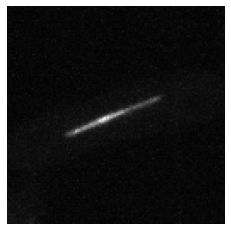

In [2]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[1], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))
img = image[0]
plt.imshow(img, cmap="gray");
plt.axis("off");

In [8]:
#def hough_transform(img): 
# initialise parameter space of all rhos and thetas
n_y, n_x = img.shape[:]
diag = int(np.sqrt(n_x**2 + n_y**2))
    
# normalise raw data to fit in [0, 1]
#normalised = (img - np.min(img)) / np.max(img - np.min(img))
normalised = img / 255
img = normalised 
    
# rhos range from -diagnoal to +diagonal of image 
rhos = np.linspace(-diag, diag, 2*diag+1)
n_rhos = len(rhos)
# thetas range from [0, pi] or [-90, 90] radians
thetas = np.deg2rad(np.linspace(0, 180, 180+1))
n_thetas = len(thetas)

# loop through line pixels 
### if image is binarised:
nonzeros = np.argwhere(img!=0)
wghts = img[nonzeros[:,0], nonzeros[:,1]] # 16351
#np.tile(wghts, n_thetas)# 2959531 = 16351*181
    
# Hough transform: get rho results 
x = np.array(nonzeros[:,1])
y = np.array(nonzeros[:,0])
n_xys = nonzeros.shape[0]

theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
cos_theta_mat = np.cos(theta_mult)
sin_theta_mat = np.sin(theta_mult)
rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)
    
# get frequency of each (theta, rho) pair 
# theta == theta_vals and rho == rho_vals 
accumulator, theta_vals, rho_vals = np.histogram2d(
    np.tile(thetas, rhos_res.shape[0]),
    rhos_res.ravel(), 
    bins = [n_thetas-1, n_rhos-1], 
    range = [np.deg2rad([0, 180]), [-diag, diag]],
    weights = np.repeat(wghts, n_thetas))

In [ ]:
accumulator_org.shape
accumulator.shape
np.max(accumulator)

In [ ]:
res = np.histogram2d(
    [1,2,3,4,5,6,7,8,9,10],
    [1,2,3,4,5,6,7,8,9,10], 
    bins = [10, 10], 
    range = [[1, 10], [1, 10]])
#    weights = img.ravel())
plt.imshow(np.transpose(res[0]), cmap="gray");
res[0]

In [ ]:
#16384 pixels of which 16351 are non-background 
#16351*181 = 2959531 thetas and rhos 
#rhos_res = 16351, 181 thetas
wghts = img[nonzeros[:,0], nonzeros[:,1]] # 16351
np.tile(wghts, n_thetas)# 2959531
#(rhos_res.ravel()).shape

In [26]:
min_dist = 15
# find local maxima 
peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = True)
#peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False)
n_peaks = peaks.shape[0]
print(n_peaks, "peaks:")
if n_peaks<10: print(peaks)
    
n_x = 128
xs = np.linspace(0, n_x-1, n_x)
# get coordinates of line in cartesian coordinates
rho_peaks = rho_vals[peaks[:,1]]
theta_peaks = theta_vals[peaks[:,0]]

cos_theta_peaks = np.cos(theta_peaks)
sin_theta_peaks = np.sin(theta_peaks)
# avoid sin(theta = 0) = 0 // can't divide by 0 
sin_theta_peaks = np.where(sin_theta_peaks == 0, 0.00001, sin_theta_peaks)

intercept = rho_peaks/sin_theta_peaks
slope = (-cos_theta_peaks) / sin_theta_peaks
slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 
ys = slope_x + intercept

4 peaks:
[[ 45 270]
 [135 181]
 [ 68 263]
 [ 76 211]]


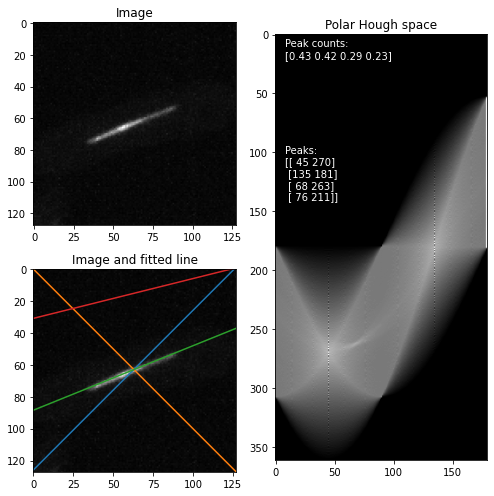

In [28]:
#accumulator, theta_vals, rho_vals = hough_transform(img)
#accumulator = accumulator*img
#xs, ys, peaks, params = conv_via_locmax(accumulator, theta_vals, rho_vals, 28)

# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
n_y, n_x = img.shape[:]
x = np.array(range(n_x))
#for i in range(peaks.shape[0]):
#    plt.plot(xs, ys[:,i], c="indianred")
plt.plot(xs, ys)
plt.xlim(0,n_x-1)
plt.ylim(n_y-1,0)
plt.title("Image and fitted line");

fig.add_subplot(122)
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.text(8, 140,("Peaks:\n"+str(peaks)),
         fontsize = 10, color = "white")
plt.text(8, 20,
         ("Peak counts:\n"+str(np.around(accumulator[peaks[:,0], peaks[:,1]], 2))),
         fontsize = 10, color = "white")

plt.title("Polar Hough space");

plt.tight_layout()
plt.savefig("figs\\exclude_borders.png", format="png", dpi=600)

- binning at ~180 is weird?
- counts are <1
- include/exclude border